## Set-Up the Environment

In [1]:
import pyabf
import slopeTools
import abfTools
import plotTools
import statsTools
import numpy as np
import matplotlib.pyplot as plt

## Moving Window Mean

This function creates a new set of data where each point is the mean of the adjacent `N` points (where `N` is defined by `windowSize`)

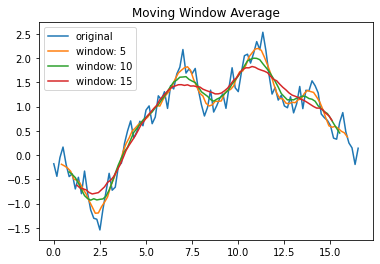

In [2]:
def demonstrateMovingWindowMean(pointCount = 100):
    """
    Demonstrate the moving window average method on random data using multiple window sizes
    """
    values = np.cumsum(np.random.random_sample(pointCount) - .5) # random walk
    times = np.arange(pointCount) * 10/60

    plt.figure()
    plt.plot(times, values, label="original")

    for windowSize in [5, 10, 15]:
        smoothValues, smoothTimes = statsTools.smoothY(values, times, windowSize) 
        plt.plot(smoothTimes, smoothValues, label=f"window: {windowSize}")
    
    plt.title("Moving Window Average")
    plt.legend()
    plt.show()
    
demonstrateMovingWindowMean()

## ABF Holding Current Slope Analysis
* Get holding current from every sweep
* Apply a moving window filter to smooth the data
* Report the slope between every data point

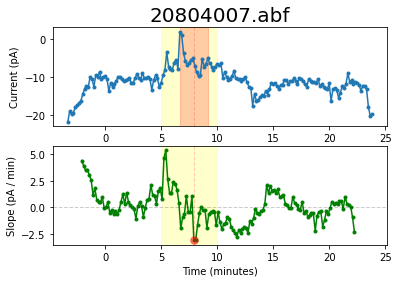

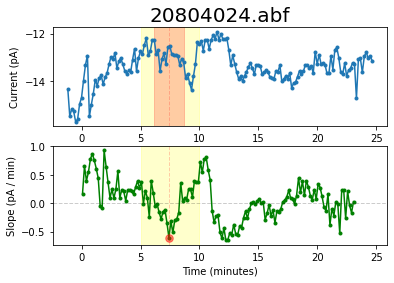

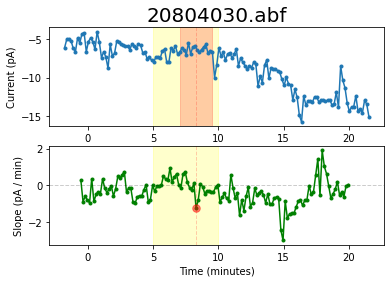

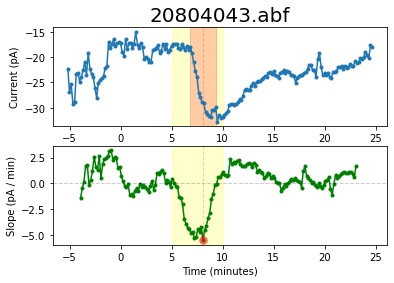

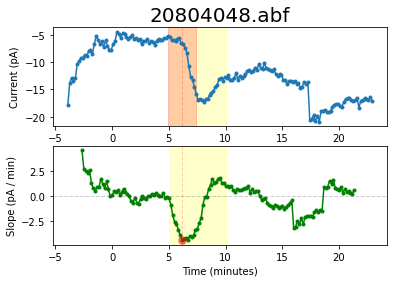

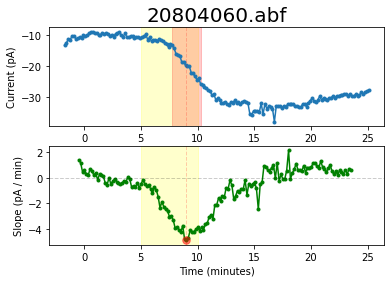

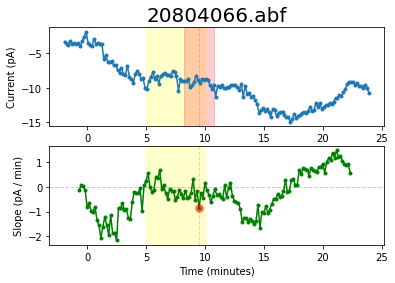

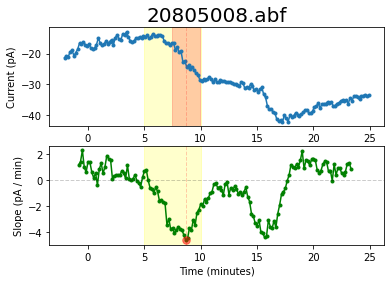

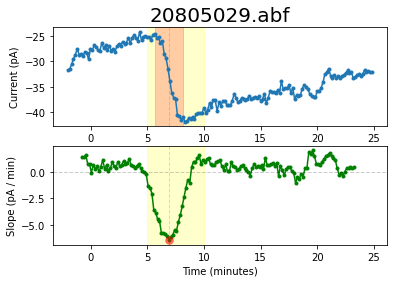

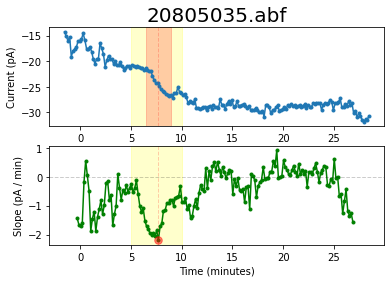

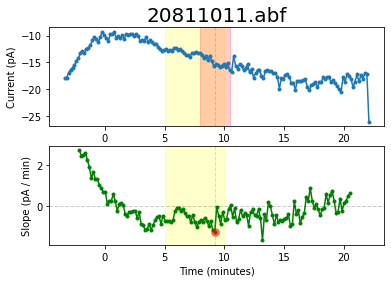

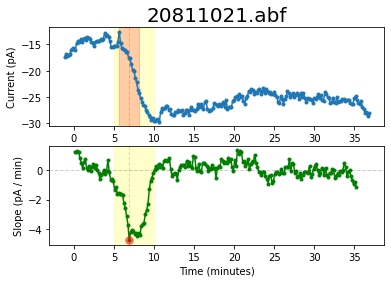

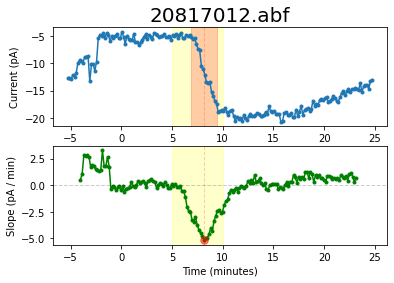

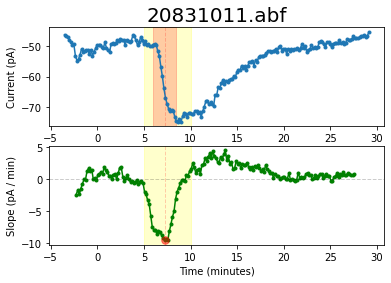

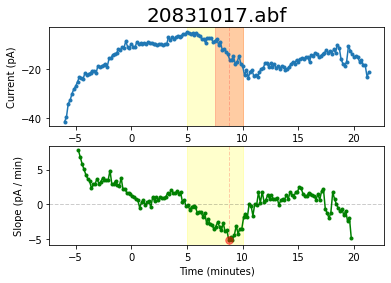

In [3]:
windowSize = 15 #sweeps
sweepLength = 10/60 #min
abfIDs = []
currentsBaseline = []
currentsDrug = []
meanSlopesBaseline = []
peakSlopesDrug = []

abfFilePaths = [
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804007.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804024.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804030.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804043.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804048.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804060.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804066.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805008.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805029.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805035.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811021.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20817012.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831017.abf"
]

for abfFilePath in abfFilePaths:
    
    # Get raw holding current
    currentsRaw, timesRaw, abfID = abfTools.meanIhold(abfFilePath)
    abfIDs.append(abfID)
    
    # Get the mean current during baseline and drug application
    currentsBaseline.append(statsTools.rangeMean(currentsRaw, timesRaw, 3, 5))
    currentsDrug.append(statsTools.rangeMean(currentsRaw, timesRaw, 6, 10))
    
    # Get smoothed holding current
    currentsSmooth, currentsSmoothTimes = statsTools.smoothY(currentsRaw, timesRaw, windowSize)
    
    # Get slopes of consecutive data points
    slopes = slopeTools.consecutiveSlopes(currentsSmooth, currentsSmoothTimes)
    currentsSmoothTimes = currentsSmoothTimes[0:len(slopes)]
        
    # Determine the time of the first tag. Later it will be aligned to be 5 minutes
    firstTagTime = abfTools.getFirstTagTime(abfFilePath)

    # Get the peak slope during a limited range of time
    peakSlopeTimeMin = 5
    peakSlopeTimeMax = 10
    peakSlope = statsTools.rangeMin(slopes, currentsSmoothTimes, peakSlopeTimeMin, peakSlopeTimeMax)
    peakSlopesDrug.append(peakSlope)
    peakSlopeIndex = slopes.index(peakSlope)
    peakSlopeTime = currentsSmoothTimes[peakSlopeIndex]
    
    #Get the mean slope during baseline (3-5 min)
    meanSlopeBaseline = statsTools.rangeMean(slopes, currentsSmoothTimes, 3, 5)
    meanSlopesBaseline.append(meanSlopeBaseline)
    
    # TODO: plot the smoothed trace on top of the raw data
    plotTools.currentSlopeTimePlot(currentsRaw, timesRaw, slopes, currentsSmoothTimes, peakSlopeTime, 
                                   peakSlope, windowSize, sweepLength, abfFilePath)

### Plot slopes before and during drug application

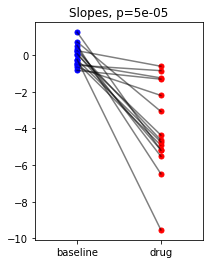

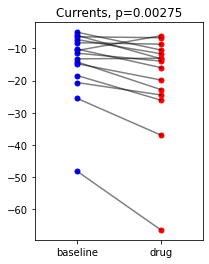

In [4]:
plotTools.plotPairs(meanSlopesBaseline, peakSlopesDrug, "Slopes")
plotTools.plotPairs(currentsBaseline, currentsDrug, "Currents")

### Report responders and non-responders based on the given criterias
1. Change of slope is larger than the defined threshold.
2. The delta holding current during drug application period is less than 0.

In [10]:
responders=[]
nonResponders=[]
for i in range(len(abfIDs)):
    responderThreshold = -1.5
    deltaSlope = round(peakSlopesDrug[i]-meanSlopesBaseline[i],3)   # pA / min
    if deltaSlope> responderThreshold:
        nonResponders.append(abfIDs[i])
    else:
        if currentsDrug[i]-currentsBaseline[i] > 0:
            nonResponders.append(abfIDs[i])
        else:
            responders.append(abfIDs[i])

responseRate = round(len(responders)/len(abfIDs)*100, 3)
print(f"Responders are: {responders}")
print(f"Non-responders are: {nonResponders}")

print(f"Response rate = {responseRate}%.")

Responders are: ['20804043', '20804048', '20804060', '20805008', '20805029', '20805035', '20811021', '20817012', '20831011', '20831017']
Non-responders are: ['20804007', '20804024', '20804030', '20804066', '20811011']
Response rate = 66.667%.
